# A Quantum Walk

$\textit{Group 1: Emil, Robin, Ege, Filippo, Netta \& Oxana}$

Performing a quantum random walk in Hilbert space:

$\mathcal{H} = \mathcal{H_c} \otimes \mathcal{H_p}$

In [96]:
#imports 
import numpy as np
import qiskit as q
import matplotlib.pyplot as plt

from qiskit.circuit.library.standard_gates import XGate, HGate

## Walk on a line

For the first example, we are going to perform a walk on the line and test, if we get the expected distributions related to the coin operators and initial coin states.

For this particular case, we are going to use the following parameters:

 - Number of position space qubits: $N_p = 7$
 - Number of coin space qubits: $N_c = 1$
 - Number of steps for each sample: $T = 100$
 - Number of samples: $n = 1000$

In [97]:
#params:
Np = 7
Nc = 1
T = 100
n = 1000            

#init:
qc = q.QuantumCircuit(Np+Nc)
it_Np = range(Np)
it_n = range(n)
it_T = range(T)


### Operators:

Coins:

$H = \frac{1}{\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}$, $X = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}$ and $C_Y = \frac{1}{\sqrt{2}} \begin{pmatrix} 1 & i \\ i & 1 \end{pmatrix}$

Forward step operator:

$S_F = \sum_{j=0}^{127} \ket{j+1}\bra{j}$

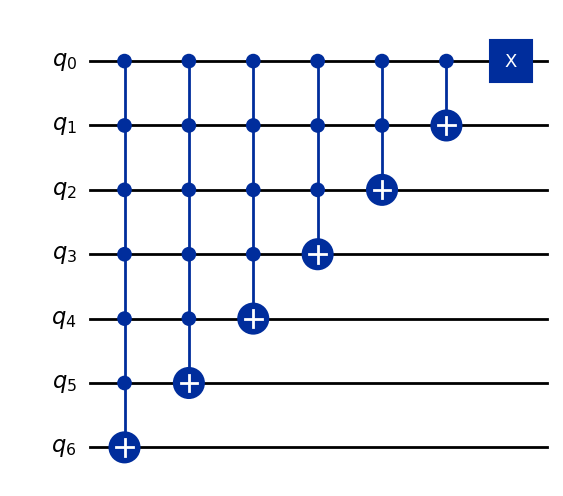

In [98]:
S_F = q.QuantumCircuit(Np)

for i in it_Np:
    current_qbit = Np-1-i
    if current_qbit == 0:
        g = XGate()
    else:
        g = XGate().control(num_ctrl_qubits=current_qbit)
    S_F.append(g, S_F.qregs[0][0:current_qbit+1])

S_F.draw("mpl")

Backward step operator:

$S_B = S_F^\dagger$

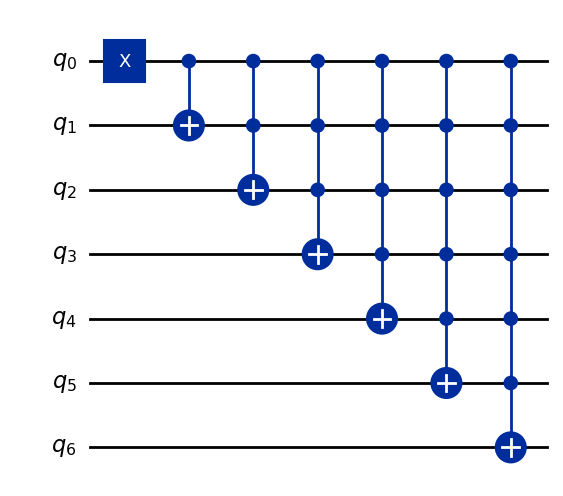

In [99]:
S_B = S_F.inverse()
S_B.draw("mpl")

The complete step operator:

$S = \ket{0}\bra{0}_c \otimes S_F + \ket{1}\bra{1}_c \otimes S_B$

We can now assemble the full Propagation operator:

$U = S \cdot (C \otimes \mathbb{1}_p)$

In [101]:
S_Fgate = S_F.to_gate().control(1)
S_Bgate = S_B.to_gate().control(1)

def propagator(num_qbits : int, coin_operator : q.circuit.Gate) -> q.circuit.Instruction:
    
    #The final building block: the propagate operator:
    U = q.QuantumCircuit(num_qbits)

    #Coin flip:
    U.append(coin_operator, U.qregs[0][0:1])

    #Controlled step forwards:
    U.append(S_Fgate, U.qregs[0])

    #Negate coin:
    U.append(XGate(), U.qregs[0][0:1])

    #Controlled step backwards:
    U.append(S_Bgate, U.qregs[0])

    #Negate coin:
    U.append(XGate(), U.qregs[0][0:1])

    return U.to_instruction()

## Running the walk:

In [ ]:
U = propagator(Np+Nc, HGate())

def perform_walk():
    for t in it_T:
        #propagate, which because of our building block method performs coinflip and stepping
        qc.append(U, qc.qregs[0])
    